In [1]:
from __future__ import print_function
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from keras.layers import Conv2DTranspose, LeakyReLU
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras import initializers
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import cv2
import math

from keras.datasets import mnist

import os

from keras.utils.vis_utils import plot_model
from keras.utils.generic_utils import Progbar

import matplotlib.pyplot as plt
from keras.models import load_model
#from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
def load_mnist_data():
    """ load mnist data """
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    #X_test = (X_test.astype(np.float32) - 127.5) / 127.5
    X_train = X_train.astype(np.float32) / 255.#20200507
    X_test = X_test.astype(np.float32) / 255. #20200507

    X_train = X_train[:,:,:,None]
    X_test = X_test[:,:,:,None]

    X_test_original = X_test.copy()

    #X_train = X_train[Y_train==0]
    #X_test = X_test[Y_test==0]
    
    #y_train = to_categorical(y_train)
    #y_test = to_categorical(y_test)
    
    print('train shape: ', X_train.shape)
    print('X_test_original shape: ', X_test_original.shape)
    print('y_train shape: ', y_train.shape)

    return X_train, X_test, X_test_original, y_train, y_test

In [3]:
X_train, X_test, X_test_original,y_train, y_test = load_mnist_data()

train shape:  (60000, 28, 28, 1)
X_test_original shape:  (10000, 28, 28, 1)
y_train shape:  (60000,)


In [4]:
ruined = X_train[:1000].copy()
y_ruined = X_train[:1000].copy()
normal = X_train[1000:2000].copy()

In [5]:
#ruined[:,3,5:15] = 1
#ruined[:,1:10,5:10] = 1

#ruined[:,12,5:20] = 1
#ruined[:,1:20,5:10] = 1
# noise range
rn = 5

# 랜덤 깨진 MNISt 만들기 
for i in range(0, ruined.shape[0]) : 
    ix = np.random.randint(0, ruined.shape[1]-rn)
    iz = np.random.randint(0, ruined.shape[1]-rn)
    ic = np.random.randint(0, ruined.shape[1]-rn)
    ruined[i, 10:20, ix:ix+rn] = 1.
    ruined[i, iz:iz+rn , 5:14] = 1.
    ruined[i, ic:ic+rn , ic:ic+rn] = 1.

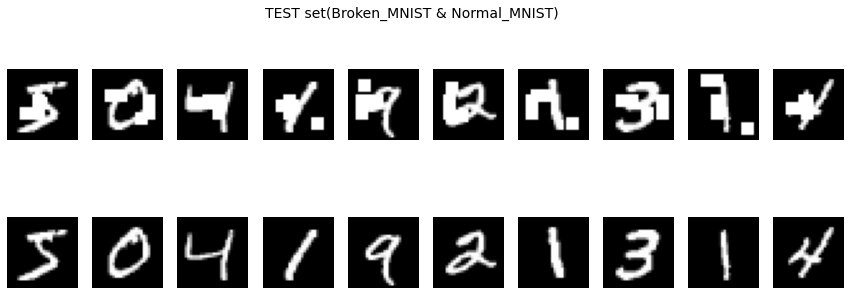

In [6]:
fig, axs = plt.subplots(2,10, figsize=(15, 5))
for i in range(10) :
    fig.suptitle('TEST set(Broken_MNIST & Normal_MNIST)', fontsize=14)
    axs[0, i].set_axis_off()
    axs[0, i].imshow(ruined[i].reshape(28,28), cmap='gray')
    axs[1, i].set_axis_off()
    axs[1, i].imshow(y_ruined[i].reshape(28,28), cmap='gray')
plt.show()
plt.close(fig)

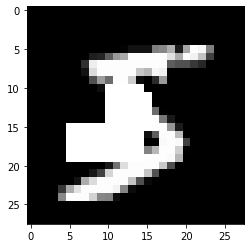

In [7]:
plt.imshow(ruined[0].reshape((28,28)), cmap='gray')

In [8]:
dmodel = load_model('./saved_model/discriminator_model.h5')
predicted_normal = dmodel.predict(normal)
predicted_ruined = dmodel.predict(ruined)

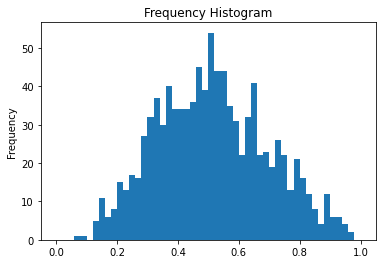

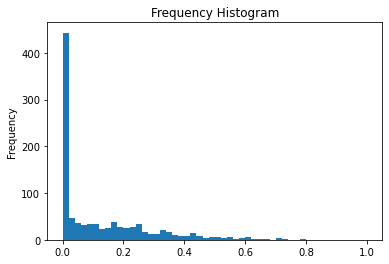

In [9]:
import matplotlib.pyplot as plt

plt.hist(predicted_normal, bins=50, range=(0,1))
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
plt.show()

plt.hist(predicted_ruined, bins=50, range=(0,1))
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [10]:
print(predicted_normal[:10])

[[0.46397138]
 [0.7249341 ]
 [0.72304165]
 [0.85219145]
 [0.51775825]
 [0.5085029 ]
 [0.5731491 ]
 [0.3974883 ]
 [0.58258957]
 [0.6908739 ]]


############ unet-model 추가

In [11]:
unet_model = load_model('./saved_model/unet.h5')

In [12]:
#이미지 차이 구하고 이미지 채널 바꾸기
def change_channel(image1,image2):
    
    diff = image1 - image2 #차이점 구하기 
    residual_ = diff.reshape((28,28))
    residual_ = np.stack((residual_,)*3, -1) # 3채널로 변경 RGB 형식
    return residual_

In [13]:
def show_rgb(rows, cols, residual_):
    for i in range(rows):
        for j in range(cols):
            for x in range(3):
                if residual_[i,j,x] == 1:
                    if x == 0:
                        residual_[i,j,x] = 1
                    else:
                        residual_[i,j,x] = 0
    
    return residual_

1/1 [==============================] - 0s 252ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


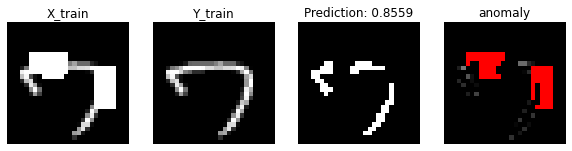

In [14]:
ix = np.random.randint(0, len(ruined))
input_ = ruined[ix:ix+1]
mask_ = y_ruined[ix:ix+1]
                       
preds_train = unet_model.predict(input_)
preds_train_t = (preds_train > 0.5).astype(np.uint8)     

plt.figure(figsize=(10,10))
plt.subplot(1,4,1)
plt.title("X_train")
plt.axis('off')
plt.imshow(input_[0].reshape(28,28),cmap='gray')
    
plt.subplot(1,4,2)
plt.title("Y_train")
plt.axis('off')
plt.imshow(mask_[0][:,:,0].reshape(28,28), cmap='gray')
    
plt.subplot(1,4,3)
ret = unet_model.evaluate(input_, mask_)
plt.title("Prediction: %.4f" % (ret[1]))
plt.axis('off')
plt.imshow(preds_train_t[0][:,:,0], cmap='gray')
    
plt.subplot(1,4,4)
train_residual_ = change_channel(input_,preds_train_t)
rows, cols, channels = train_residual_.shape
train_residual_ = show_rgb(rows,cols,train_residual_)
plt.title("anomaly")
plt.axis('off')
plt.imshow(train_residual_, cmap='gray')
plt.show()

In [15]:
dcgan_preds_train = unet_model.predict(ruined)
dcgan_predicted_ruined = dmodel.predict(dcgan_preds_train)

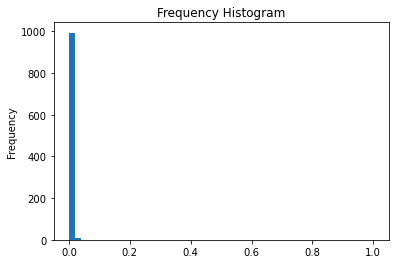

In [16]:
plt.hist(dcgan_predicted_ruined, bins=50, range=(0,1))
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
plt.show()

In [17]:
#0.5 정도로 해서 구분한다
dcgan_predict_up = []
dcgan_predict_down = []
for i in range(0,1000) :
    if dcgan_predicted_ruined[i] > 0.5 :
        dcgan_predict_up.append(i)
    else:
        dcgan_predict_down.append(i)

IndexError: list index out of range

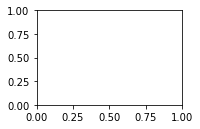

In [18]:
count = 0
nrows = ncols = 4

plt.figure(figsize=(12,8))

for n in range(12):
    count += 1
    plt.subplot(nrows, ncols, count)
    plt.title("Prediction: %.2f" % (dcgan_predicted_ruined[dcgan_predict_up[n]]))
    plt.imshow(dcgan_preds_train[dcgan_predict_up[n]][:,:,0], cmap='gray')

plt.tight_layout()
plt.show()

In [ ]:
count = 0
nrows = ncols = 4

plt.figure(figsize=(12,8))

for n in range(12):
    count += 1
    plt.subplot(nrows, ncols, count)
    plt.title("Prediction: %.2f" % ( dcgan_predicted_ruined[dcgan_predict_down[n]]))
    plt.imshow(dcgan_preds_train[dcgan_predict_down[n]][:,:,0], cmap='gray')

plt.tight_layout()
plt.show()